In [58]:
import face_alignment
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import time

#fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False, device='cpu')
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device='cpu', face_detector='blazeface')


face_landmarks = {
    'Jaw': {'range': (0, 17), 'color': (0, 255, 255)},        # Cyan for Jaw
    'Eyebrows': {'range': (17, 27), 'color': (255, 255, 0)},  # Yellow for Eyebrows
    'Nose': {'range': (27, 36), 'color': (255, 0, 0)},        # Blue for Nose
    'Eyes': {'range': (36, 48), 'color': (0, 0, 255)},        # Red for Eyes
    'Outer Lips': {'range': (48, 60), 'color': (255, 0, 255)},# Magenta for Outer Lips
    'Inner Lips': {'range': (60, 68), 'color': (128, 0, 128)} # Purple for Inner Lips
}

eye_threshold = 5
jaw_threshold = 5
mouth_threshold = 8

In [50]:
cap = cv2.VideoCapture('data/fake/a_numbers_fake.mp4')
frames = []
while True:
    success, frame = cap.read()
    if not success:
        break
    
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #frame = cv2.resize(frame, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_LINEAR)

    frames.append(frame)

BlazeFace: Execution time for a single image: 0.5930225849151611


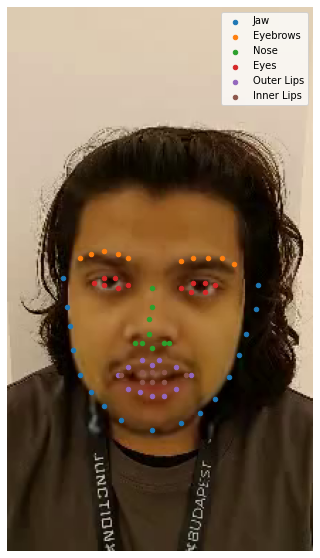

In [20]:
t_start = time.time()
preds = fa.get_landmarks_from_image(frames[0])
print(f'BlazeFace: Execution time for a single image: {time.time() - t_start}')

plt.figure(figsize=(10,10))
plt.imshow(frames[0])
plt.axis('off')

for detection in preds:
    x_values = detection[:, 0]
    y_values = detection[:, 1]

    # Plot all points using scatter plot with specific colors for facial parts
    for part, (start, end) in face_landmarks.items():
        plt.scatter(x_values[start:end], y_values[start:end], s=20, label=part)

plt.legend()


In [62]:
cap = cv2.VideoCapture('data/raw/a_numbers.mp4')
frames = []
while True:
    success, frame = cap.read()
    if not success:
        break
    
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #frame = cv2.resize(frame, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_LINEAR)

    frames.append(frame)

# Initialize VideoWriter parameters
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

fps = 30  # Change the frames per second as needed

output_file = 'results/facial_features2.mp4'
frame_width, frame_height = frames[0].shape[1], frames[0].shape[0]

# Create VideoWriter object
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

# Process frames in batches and write to the video
batch_size = 16
num_frames = len(frames)


In [63]:
for i in range(0, num_frames, batch_size):
    batch_frames = frames[i:i+batch_size]
    
    # Convert frames to the required format (assuming frames are in BGR format)
    batch = np.stack(batch_frames)
    batch = torch.Tensor(batch.transpose(0, 3, 1, 2))
    
    t_start = time.time()
    preds = fa.get_landmarks_from_batch(batch)
    print(f'BlazeFace: Execution time for batch {i+1}-{min(i+batch_size, num_frames)}: {time.time() - t_start}')
    
    # Visualize results and write to video
    for j, pred in enumerate(preds):
        frame_index = i + j
        if frame_index < num_frames:
            frame = frames[frame_index]
            
            #Change facial features
            if(j > 1):
                #Eye threshold check
                delta = preds[j][36:48] - preds[j-1][36:48]
                result = np.all(np.abs(delta) >= eye_threshold)

                if(result):
                    print("Eye threshold passed. Frame: ", frame_index)
                    break

                #Mouth threshold check
                delta = preds[j][48:60] - preds[j-1][48:60]
                result = np.all(np.abs(delta) >= eye_threshold)

                if(result):
                    print("Mouth threshold passed. Frame: ", frame_index)
                    break
                
                #Jaw threshold check
                delta = preds[j][:17] - preds[j-1][:17]
                result = np.all(np.abs(delta) >= jaw_threshold)

                if(result):
                    print("Jaw threshold passed. Frame: ", frame_index)
                    break
                    

            x_values = pred[:, 0].astype(np.int64)
            y_values = pred[:, 1].astype(np.int64)

            # Plot all points using scatter plot with specific colors for facial parts
            for part, part_info in face_landmarks.items():
                start, end = part_info['range']
                color = part_info['color']
    
                # Draw circles for each facial part with different colors
                for i in range(start, end):
                    cv2.circle(frame, (int(x_values[i]), int(y_values[i])), 2, color, -1)

            
            # Write the frame with landmarks to the video
            out.write(frame)

# Release the VideoWriter and close the output file
out.release()


BlazeFace: Execution time for batch 1-16: 4.182645797729492
BlazeFace: Execution time for batch 17-32: 4.13558292388916
BlazeFace: Execution time for batch 33-48: 3.990413188934326
BlazeFace: Execution time for batch 49-64: 3.997390031814575
BlazeFace: Execution time for batch 65-80: 3.9718174934387207
BlazeFace: Execution time for batch 81-96: 4.196029424667358
BlazeFace: Execution time for batch 97-112: 4.212429523468018
BlazeFace: Execution time for batch 113-128: 4.338984727859497
BlazeFace: Execution time for batch 129-144: 4.3034446239471436
BlazeFace: Execution time for batch 145-160: 4.3350749015808105
BlazeFace: Execution time for batch 161-176: 4.3181092739105225
BlazeFace: Execution time for batch 177-192: 4.3408427238464355
BlazeFace: Execution time for batch 193-208: 4.338464736938477
Mouth threshold passed. Frame:  75
BlazeFace: Execution time for batch 209-224: 4.610101699829102
Eye threshold passed. Frame:  75
BlazeFace: Execution time for batch 225-240: 4.6268990039825

In [57]:
pred

array([[ 40., 190.],
       [ 40., 209.],
       [ 42., 224.],
       [ 44., 241.],
       [ 49., 257.],
       [ 59., 272.],
       [ 68., 284.],
       [ 80., 294.],
       [100., 301.],
       [121., 296.],
       [133., 286.],
       [143., 277.],
       [152., 262.],
       [160., 245.],
       [164., 229.],
       [169., 212.],
       [172., 195.],
       [ 49., 176.],
       [ 56., 173.],
       [ 66., 171.],
       [ 76., 173.],
       [ 85., 178.],
       [119., 178.],
       [128., 176.],
       [138., 176.],
       [150., 176.],
       [157., 181.],
       [102., 197.],
       [100., 209.],
       [100., 219.],
       [100., 229.],
       [ 90., 236.],
       [ 92., 238.],
       [100., 238.],
       [107., 238.],
       [112., 236.],
       [ 61., 193.],
       [ 68., 190.],
       [ 76., 190.],
       [ 83., 195.],
       [ 76., 197.],
       [ 68., 195.],
       [121., 197.],
       [128., 193.],
       [138., 193.],
       [145., 197.],
       [138., 200.],
       [128.,